# VAE from astroml : training one latent variable

https://www.astroml.org/book_figures/chapter9/fig_sdss_vae.html


- creation 2023-04-25
- update : 2023-04-26


In [1]:
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

# Import some generally useful packages

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata

#from astroML.datasets import sdss_corrected_spectra

# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

/Users/dagoret/anaconda3/envs/fidle23/lib/python3.9/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [3]:
from sklearn.model_selection import train_test_split
import h5py

In [39]:
hf = h5py.File('SLspectra.hdf5', 'r') 
data_in = hf['flambda'][:]
wl_in = hf['wl'][:]
target = hf['quantile'][:]

# other data
redshift = hf['redshift'][:]
Rmag = hf['Rmag'][:]
RT = hf['RT'][:]
RV = hf['RV'][:]
ra = hf['ra'][:]
dec = hf['dec'][:]
fracinfbalmer = hf['fracinfbalmer'][:]
print(hf.keys())

<KeysViewHDF5 ['Nsp', 'RT', 'RV', 'Rmag', 'dec', 'eRV', 'flambda', 'fracinfbalmer', 'num', 'quantile', 'ra', 'redshift', 'wl']>


In [44]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(1-fracinfbalmer, alpha=1)

/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_74542/722139017.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(fracinfbalmer,target,color=all_colors,cmap=jet)


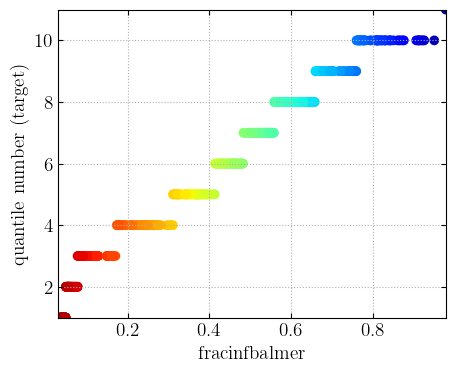

In [52]:
fig = plt.figure(figsize=(5,4))
ax=fig.add_subplot(1,1,1)
ax.scatter(fracinfbalmer,target,color=all_colors,cmap=jet)
ax.set_xlabel("fracinfbalmer")
ax.set_ylabel("quantile number (target)")
ax.grid()

In [5]:
WL_BALMER_BREAK= 3646.0 
WL = wl_in
NWL = data_in.shape[1]
NSAMPL = data_in.shape[0]

In [6]:
idx_blue = np.where (WL<WL_BALMER_BREAK)[0]
idx_red = np.where (WL>=WL_BALMER_BREAK)[0]
wl_blue = WL[idx_blue]
wl_red = WL[idx_red]

In [7]:
#x_train, x_test, y_train, y_test = train_test_split(data_in,
#                                          target,
#                                          test_size=0.2)

In [8]:
# Fetch and prepare the data
#data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
#spectra = sdss_corrected_spectra.reconstruct_spectra(data)
#wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

spectra = data_in
wavelengths = wl_in

# normalize spectra by integrated flux and subtract out mean, for easier training
spectranorms = np.mean(spectra, axis=1)
normedspectra = spectra / spectranorms[:, None]

#already normalized spectra in prepareData, but it does not work ????
#normedspectra = spectra

meanspectrum = np.mean(normedspectra, axis=0)
normedspectra -= meanspectrum[None, :]

# split data into 3:1 train:test
torch.manual_seed(802)  # seed used for book figure
dataset = torchdata.TensorDataset(torch.tensor(normedspectra))
trainnum = normedspectra.shape[0] // 4 * 3
traindata, testdata = torchdata.random_split(dataset, [trainnum, normedspectra.shape[0] - trainnum])
traindataloader = torchdata.DataLoader(traindata, batch_size=64, shuffle=True)

# Definition of VAE model 

In [9]:
# define structure of variation autoencoder
class VAE(nn.Module):
    def __init__(self, nhidden=250):
        super(VAE, self).__init__()

        self.encode_fc = nn.Linear(NWL, nhidden)
        self.mu        = nn.Linear(nhidden, 1)
        self.logvar    = nn.Linear(nhidden, 1)

        self.decode_fc = nn.Linear(1, nhidden)
        self.output    = nn.Linear(nhidden, NWL)

    def encode(self, x):
        h = F.relu(self.encode_fc(x))
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h = F.relu(self.decode_fc(z))
        return self.output(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# add KL divergence to loss function
def VAEloss(criterion, recon_x, x, mu, logvar):
    return criterion(recon_x, x) - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


all_train_loss = []
all_valid_loss = []


def train_model():
    
    model = VAE()
    criterion = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5, threshold=1e-3)

    min_valid_loss = float('inf')
    badepochs = 0
    for t in range(10000):
        train_loss = 0
        for i, databatch in enumerate(traindataloader, 0):
            specbatch = databatch[0]
            optimizer.zero_grad()
            recon, mu, logvar = model(specbatch)
            loss = VAEloss(criterion, recon, specbatch, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        all_train_loss.append(train_loss)
        
        with torch.no_grad():
            testspec = testdata[:][0]
            recon, mu, logvar = model(testspec)
            valid_loss = VAEloss(criterion, recon, testspec, mu, logvar)
            
            all_valid_loss.append(valid_loss)
            
            if t % 10 == 0:
                print('Epoch %3i: train loss %6.1f validation loss %6.1f' % \
                        (t, train_loss / len(traindata), valid_loss / len(testdata)))
            # stop training if validation loss has not fallen in 10 epochs
            if valid_loss > min_valid_loss*(1-1e-3):
                badepochs += 1
            else:
                min_valid_loss = valid_loss
                badepochs = 0
            if badepochs == 10:
                print('Finished training')
                break
        scheduler.step(valid_loss)
    return model

In [10]:
model = train_model()

Epoch   0: train loss 9861.4 validation loss 9338.5
Epoch  10: train loss 5315.3 validation loss 4795.7
Epoch  20: train loss 1696.2 validation loss 1833.4
Epoch  30: train loss 1547.7 validation loss 1689.7
Epoch  40: train loss 1475.9 validation loss 1597.8
Epoch  50: train loss 1406.7 validation loss 1537.3
Epoch  60: train loss 1355.2 validation loss 1482.9
Epoch  70: train loss 1308.9 validation loss 1424.9
Epoch  80: train loss 1269.6 validation loss 1395.7
Epoch  90: train loss 1240.0 validation loss 1372.1
Epoch 100: train loss 1213.2 validation loss 1357.7
Epoch 110: train loss 1187.1 validation loss 1335.0
Epoch 00113: reducing learning rate of group 0 to 1.0000e-05.
Epoch 120: train loss 1168.0 validation loss 1315.8
Epoch 00121: reducing learning rate of group 0 to 1.0000e-06.
Epoch 130: train loss 1166.5 validation loss 1312.7
Epoch 00132: reducing learning rate of group 0 to 1.0000e-07.
Finished training


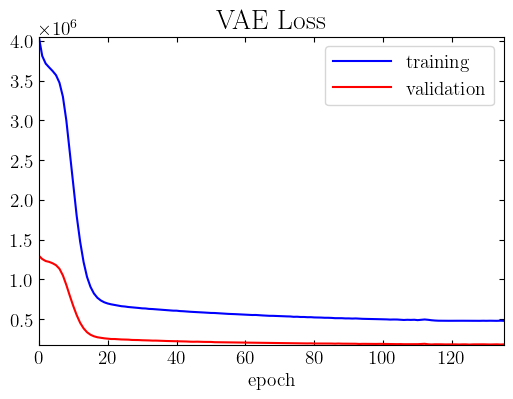

In [11]:
fig = plt.figure(figsize=(6,4))
ax=fig.add_subplot(1,1,1)
ax.plot(all_train_loss,'b-',label='training')
ax.plot(all_valid_loss,'r-',label="validation")
ax.set_title("VAE Loss",fontsize=20)
ax.set_xlabel("epoch")
ax.legend()

## Save model

In [12]:
#torch.save(model,"modelvae_fromastroml_pytorch_v1.pth")
torch.save(model.state_dict(),"modelvae_fromastroml_pytorch_1latentvariable.pth")

## plot result

In [13]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
#all_colors2 = scalarMap2.to_rgba(all_redshifts, alpha=1)

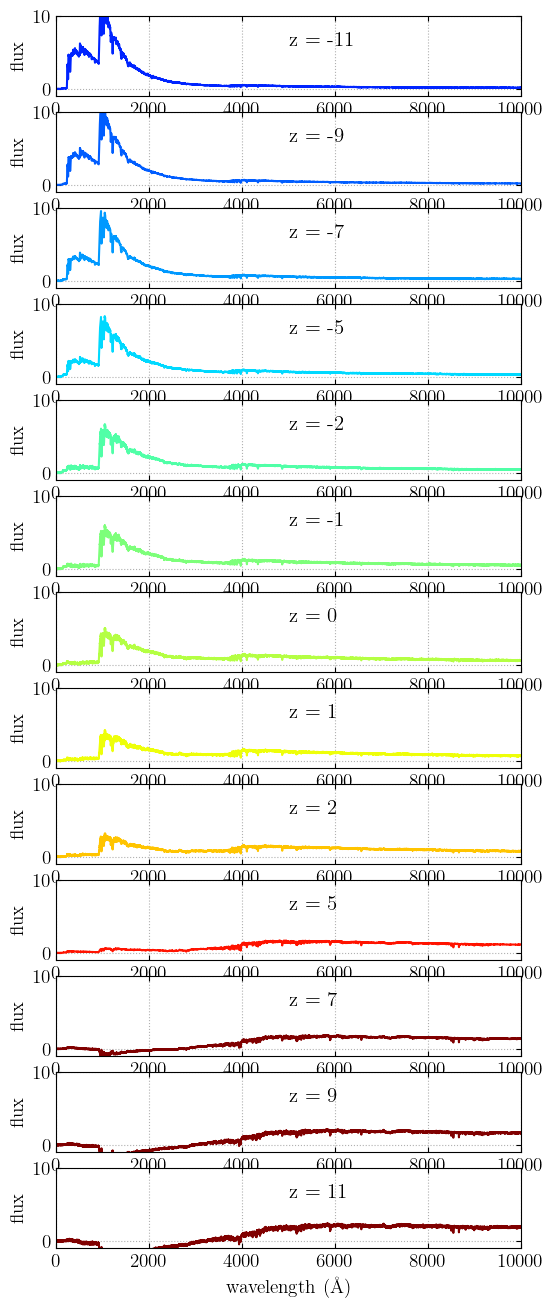

In [14]:
# plot results

with torch.no_grad():
    # sort latent parameters from most constrained to least constrained
    testspec = dataset[:][0]
    recon, mu, logvar = model(testspec)
    zorder = np.argsort(np.mean(logvar.numpy(), axis=0))

    fig = plt.figure(figsize=(6,16))
    #fig.subplots_adjust(hspace=0, wspace=0)
    
    #values of the latent variable grid
    parvalues = [-11,-9,-7,-5,-2.,-1,0.,1,2.,5,7,9,11]
    
    for i, z1 in enumerate(parvalues):
     
        idx_fig = i +1
            
        
        ax = fig.add_subplot(13, 1, idx_fig)

        z = np.zeros((1,1), dtype=np.float32)
        z[0, 0] = z1  # set z1 is more constrained of the two latent parameters
        
        
        spectrum = model.decode(torch.tensor(z))
        dspectrum = spectrum.numpy()[0,:]
        fullspectrum = meanspectrum+dspectrum
            
        flux_blue = fullspectrum[idx_blue]
        flux_red  = fullspectrum[idx_red]
        flux_integ=np.zeros(7)
        flux_integ[0] =  np.trapz(flux_blue ,wl_blue)
        flux_integ[1] =  np.trapz(flux_red ,wl_red)
        flux_integ[2] = flux_integ[0] + flux_integ[1] 
        flux_integ[3] = flux_integ[0] / flux_integ[2] 
        flux_integ[4] = flux_integ[1] / flux_integ[2] 
        flux_integ[5] = flux_integ[0] / flux_integ[1] 
        flux_integ[6] = flux_integ[1] / flux_integ[0] 
            
        # want red galaxies being red and blue galaxies being blue
        color_spec = scalarMap.to_rgba(1-flux_integ[3], alpha=1)
    
        
        ax.plot(wavelengths,fullspectrum ,color=color_spec)
        #spectrum = model.decode(torch.tensor(z))
        #ax.plot(wavelengths, meanspectrum+spectrum.numpy()[0,:],'b-')
        ax.grid()
        ax.text(5000, 6, 'z = %i' % (z1),fontsize=15)

        ax.set_xlim(0, 10000)
        ax.set_ylim(-1, 10)

        
        ax.set_ylabel('flux')     
        ax.set_xlabel(r'${\rm wavelength\ (\AA)}$')
#plt.tight_layout()         
plt.show()

# Explore latent space

In [15]:
alldatasetloader = torchdata.DataLoader(dataset , batch_size=64, shuffle=False)

In [16]:
all_latent_var_subset = []
all_latent_logvar_subset = []
for i, databatch in enumerate(alldatasetloader, 0):
    specbatch = databatch[0]
    recon, mu, logvar = model(specbatch)
    all_latent_var_subset.append(mu.detach().numpy())
    all_latent_logvar_subset.append(logvar.detach().numpy())

### regroup all batches

In [17]:
all_latent_var = np.concatenate(all_latent_var_subset, axis=0)
all_latent_logvar = np.concatenate(all_latent_logvar_subset, axis=0)

## Color palets

In [94]:
cmap_jet = plt.cm.get_cmap('jet', 10) 
col =cmap_jet(10-target)

/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_74542/3943774209.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_jet = plt.cm.get_cmap('jet', 10)


In [90]:
cmap_jet = plt.cm.get_cmap('jet') 
# want red galaxies being red and blue galaxies being blue
Norm = colors.Normalize(vmin=1, vmax=1)
scalarMap= cmx.ScalarMappable(norm=cNorm, cmap=cmap_jet)
all_colors = scalarMap10.to_rgba(1-fracinfbalmer, alpha=1)

/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_74542/2741620140.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_jet = plt.cm.get_cmap('jet')


In [82]:
jet10 = plt.get_cmap('jet')
cNorm10 = colors.Normalize(vmin=1, vmax=10)
scalarMap10 = cmx.ScalarMappable(norm=cNorm10, cmap=jet10)
all_colors10 = scalarMap10.to_rgba(np.arange(10,0,-1), alpha=1)

## Plot latent variable

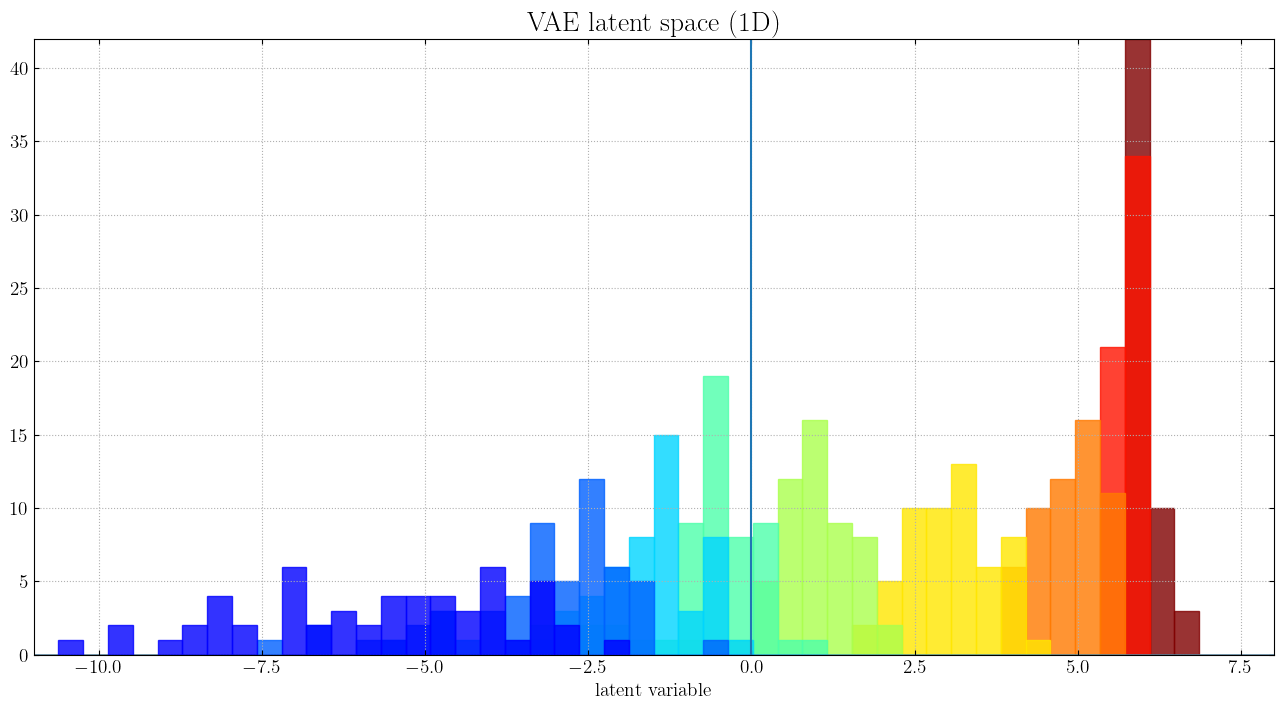

In [108]:
# number of quantiles
NQ=10
#fig = plt.figure(figsize=(8,4))
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(1,1,1)

for idx in range(1,NQ):
    selected_indexes = np.where(target==idx)[0]
    latent_variable = all_latent_var[selected_indexes,0]
    the_color=all_colors10[idx-1]
    ax.hist(latent_variable, bins=50,range=(-11,8),edgecolor=the_color,facecolor=the_color,alpha=0.8)
    ax.set_title("VAE latent space (1D)",fontsize=20)
    ax.set_xlabel("latent variable")

ax.axvline(0)
ax.grid()

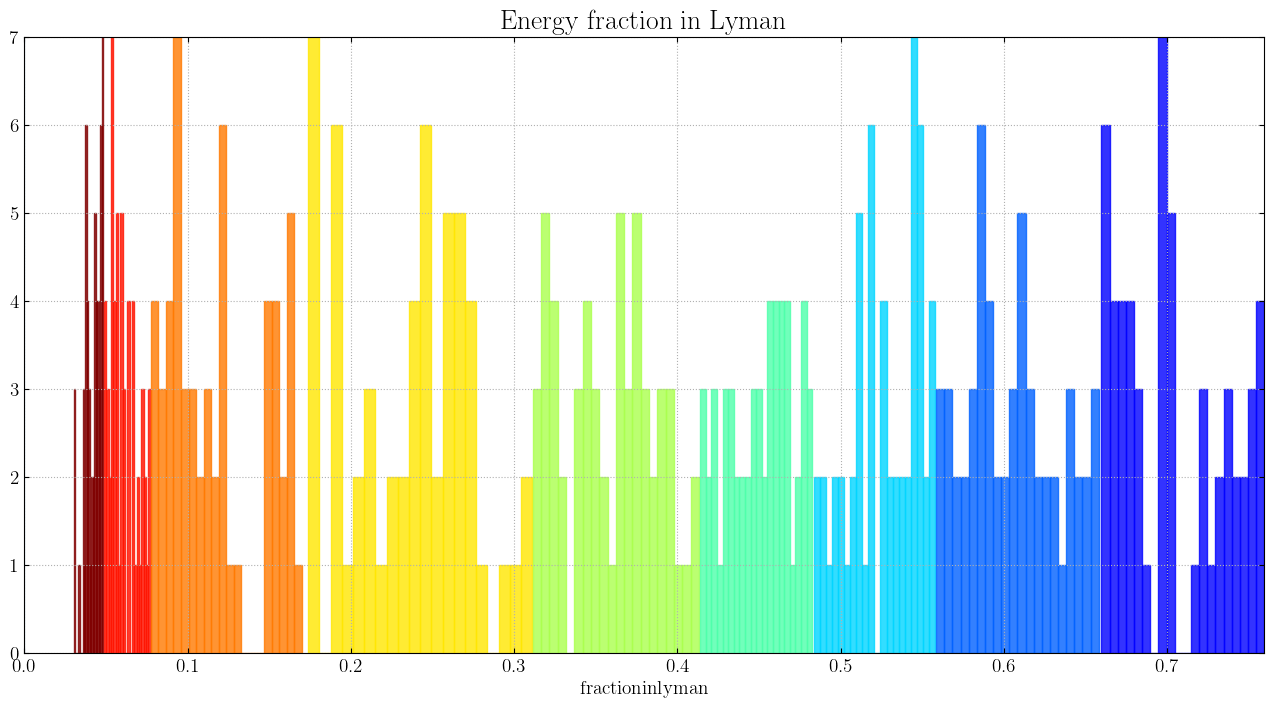

In [109]:
fig = plt.figure(figsize=(16,8))
#fig = plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)

for idx in range(1,NQ):
    selected_indexes = np.where(target==idx)[0]
    fractioninlyman = fracinfbalmer[selected_indexes]
    the_color=all_colors10[idx-1] 
    ax.hist(fractioninlyman, bins=20,edgecolor=the_color,facecolor=the_color,alpha=0.8)
    ax.set_title("Energy fraction in Lyman",fontsize=20)
    ax.set_xlabel("fractioninlyman")

ax.axvline(0)
ax.grid()


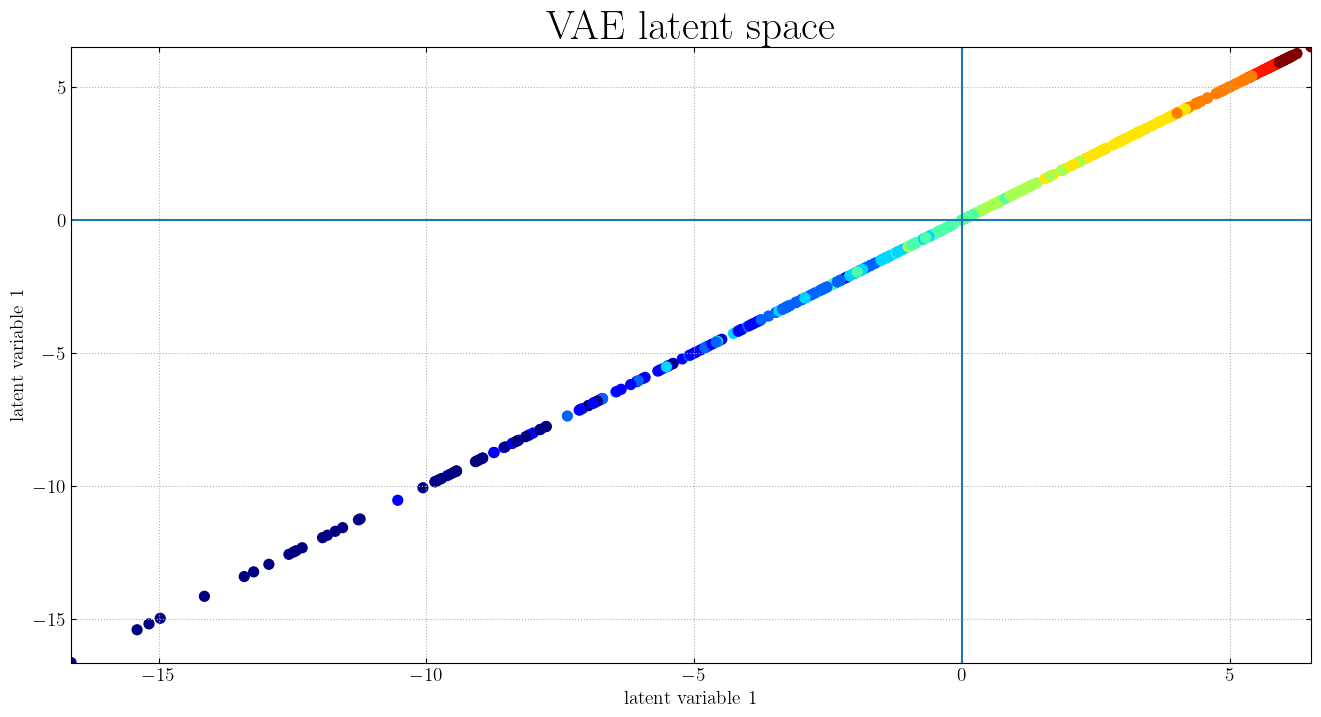

In [107]:
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(1,1,1)
ax.scatter(all_latent_var[:,0],all_latent_var[:,0], c=col, edgecolors='face',marker="o" ,s=50)
ax.set_title("VAE latent space",fontsize=30)
ax.set_xlabel("latent variable 1")
ax.set_ylabel("latent variable 1")
ax.axvline(0)
ax.axhline(0)
ax.grid()

In [96]:
all_latent_sigma  = np.sqrt(np.exp(all_latent_logvar)) 

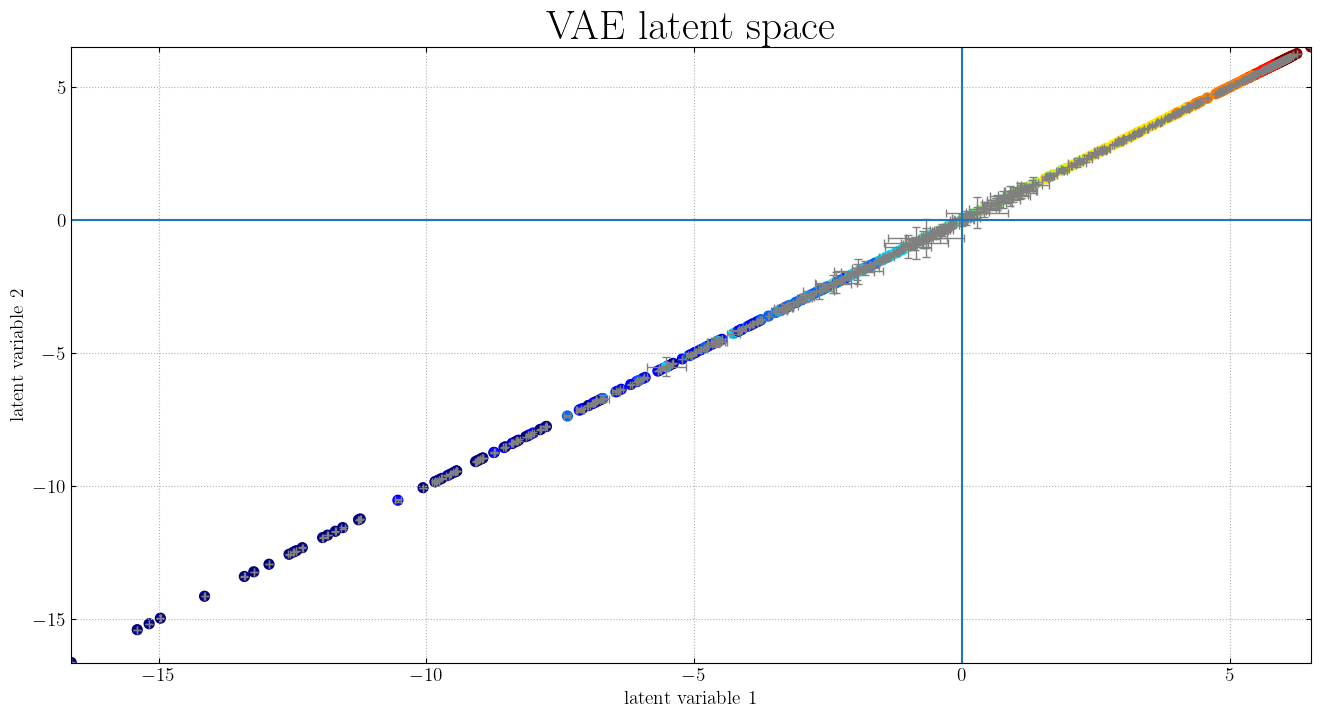

In [97]:
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(1,1,1)
#plt.scatter(all_latent_var[:,0],all_latent_var[:,1], c=col, edgecolors='face',marker="o" ,s=50)
ax.errorbar(all_latent_var[:,0],all_latent_var[:,0], xerr=all_latent_sigma[:,0], yerr=all_latent_sigma[:,0],fmt=' ',ecolor='grey', elinewidth=1) 
ax.scatter(all_latent_var[:,0],all_latent_var[:,0], c=col, edgecolors='face',marker="o" ,s=50)
#             markeredgecolor=col,
#             markerfacecolor=col,
             
ax.set_title("VAE latent space",fontsize=30)
ax.set_xlabel("latent variable 1")
ax.set_ylabel("latent variable 2")
ax.axvline(0)
ax.axhline(0)
ax.grid()

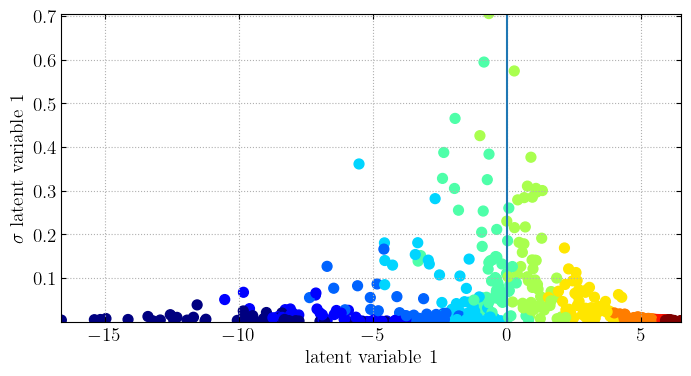

In [98]:
xlabel = ["latent variable 1","latent variable 2"]
ylabel =  ["$\sigma$ latent variable 1","$\sigma$ latent variable 2"]
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.scatter(all_latent_var[:,0],all_latent_sigma[:,0], c=col, edgecolors='face',marker="o" ,s=50)
ax.set_xlabel(xlabel[0])
ax.set_ylabel(ylabel[0])
ax.axvline(0)
ax.grid()

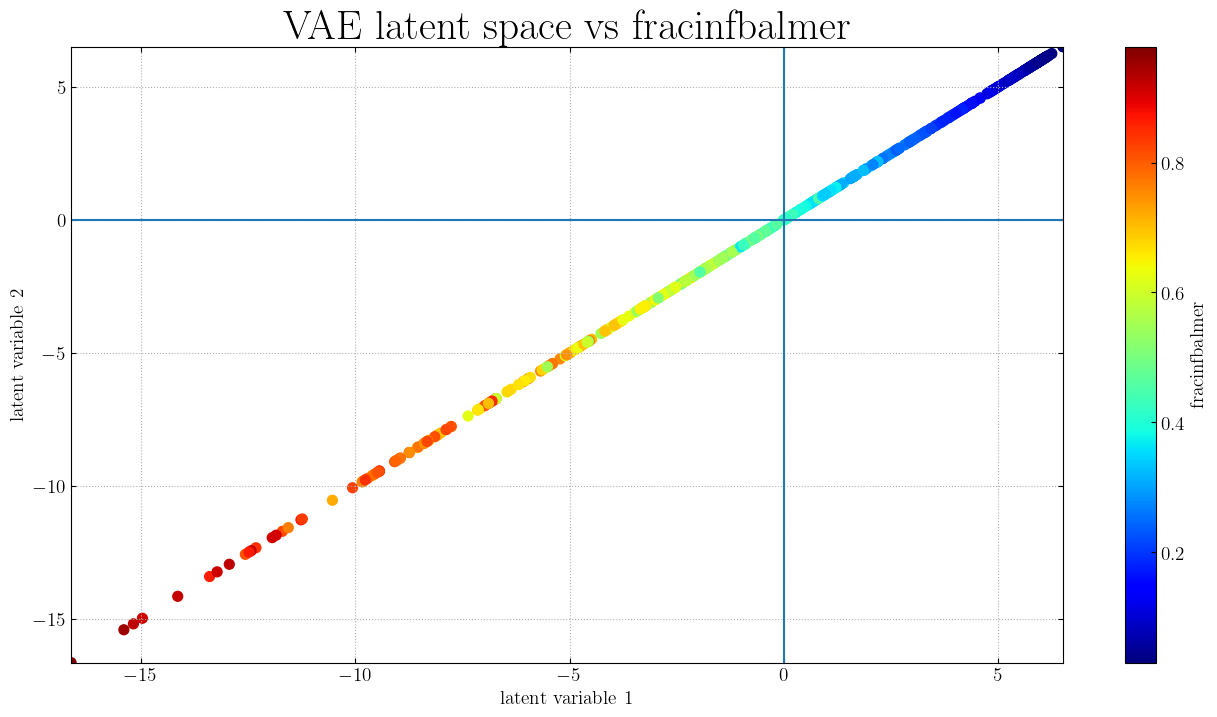

In [99]:
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(1,1,1)
#plt.scatter(all_latent_var[:,0],all_latent_var[:,1], c=col, edgecolors='face',marker="o" ,s=50)
#ax.errorbar(all_latent_var[:,0],all_latent_var[:,1], xerr=all_latent_sigma[:,0], yerr=all_latent_sigma[:,1],fmt='.',facecolor=None,ecolor='grey', elinewidth=1) 
im = ax.scatter(all_latent_var[:,0],all_latent_var[:,0], c=fracinfbalmer, edgecolors='face',marker="o" ,s=50,cmap="jet")
#             markeredgecolor=col,
#             markerfacecolor=col,
cbar = plt.colorbar(im,ax=ax)
cbar.set_label('fracinfbalmer')             
ax.set_title("VAE latent space vs fracinfbalmer",fontsize=30)
ax.set_xlabel("latent variable 1")
ax.set_ylabel("latent variable 2")
ax.axvline(0)
ax.axhline(0)
ax.grid()

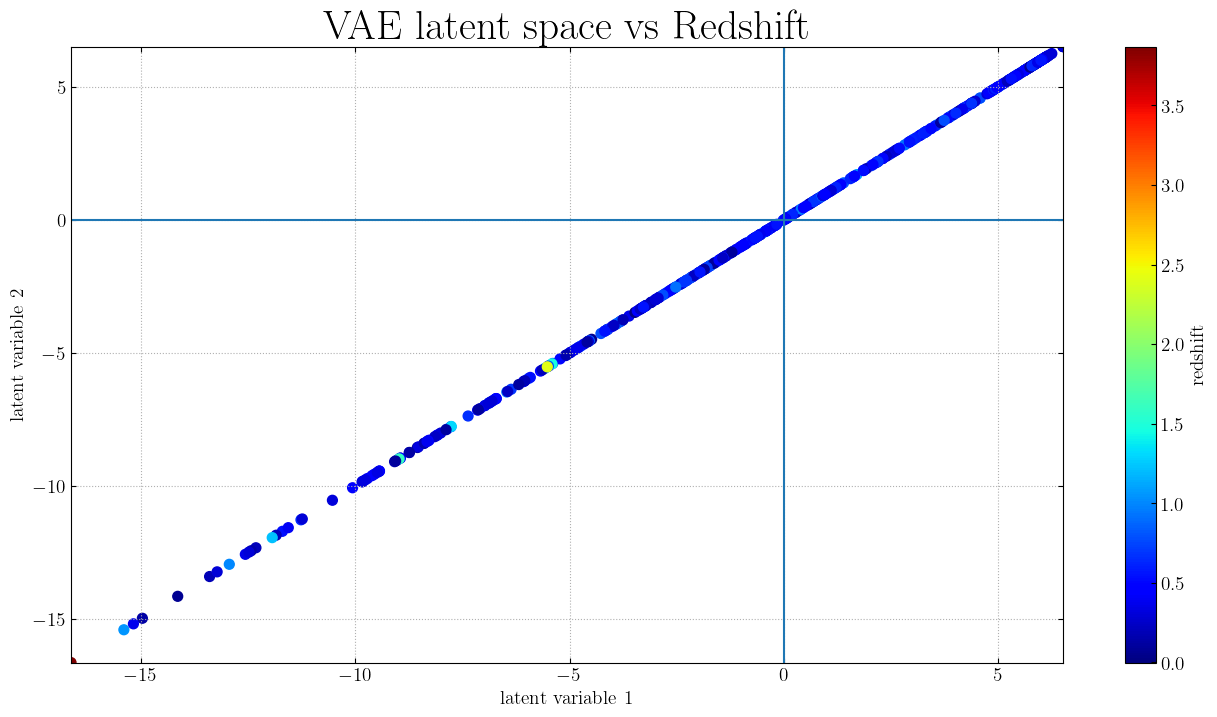

In [100]:
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(1,1,1)
#plt.scatter(all_latent_var[:,0],all_latent_var[:,1], c=col, edgecolors='face',marker="o" ,s=50)
#ax.errorbar(all_latent_var[:,0],all_latent_var[:,1], xerr=all_latent_sigma[:,0], yerr=all_latent_sigma[:,1],fmt='.',facecolor=None,ecolor='grey', elinewidth=1) 
im = ax.scatter(all_latent_var[:,0],all_latent_var[:,0], c=redshift, edgecolors='face',marker="o" ,s=50,cmap="jet")
#             markeredgecolor=col,
#             markerfacecolor=col,
cbar = plt.colorbar(im,ax=ax)
cbar.set_label('redshift')             
ax.set_title("VAE latent space vs Redshift",fontsize=30)
ax.set_xlabel("latent variable 1")
ax.set_ylabel("latent variable 2")
ax.axvline(0)
ax.axhline(0)
ax.grid()


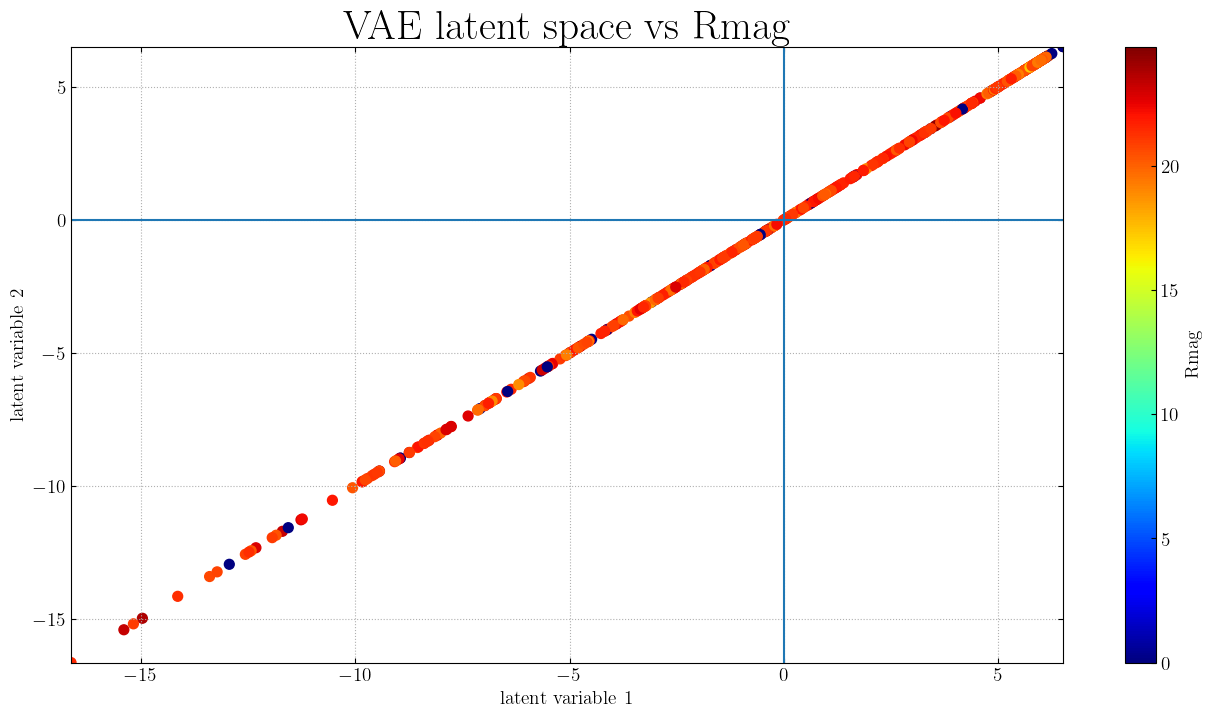

In [101]:
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(1,1,1)
#plt.scatter(all_latent_var[:,0],all_latent_var[:,1], c=col, edgecolors='face',marker="o" ,s=50)
#ax.errorbar(all_latent_var[:,0],all_latent_var[:,1], xerr=all_latent_sigma[:,0], yerr=all_latent_sigma[:,1],fmt='.',facecolor=None,ecolor='grey', elinewidth=1) 
im = ax.scatter(all_latent_var[:,0],all_latent_var[:,0], c=Rmag, edgecolors='face',marker="o" ,s=50,cmap="jet")
#             markeredgecolor=col,
#             markerfacecolor=col,
cbar = plt.colorbar(im,ax=ax)
cbar.set_label('Rmag')             
ax.set_title("VAE latent space vs Rmag",fontsize=30)
ax.set_xlabel("latent variable 1")
ax.set_ylabel("latent variable 2")
ax.axvline(0)
ax.axhline(0)
ax.grid()


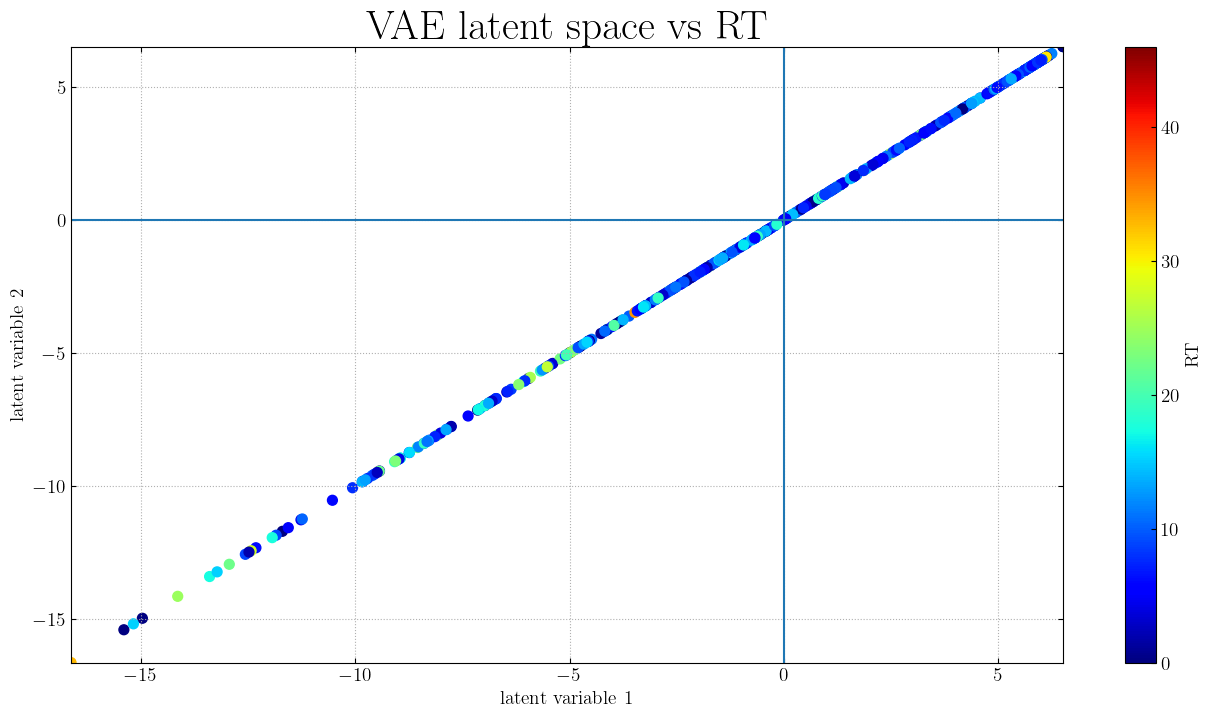

In [30]:
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(1,1,1)
#plt.scatter(all_latent_var[:,0],all_latent_var[:,1], c=col, edgecolors='face',marker="o" ,s=50)
#ax.errorbar(all_latent_var[:,0],all_latent_var[:,1], xerr=all_latent_sigma[:,0], yerr=all_latent_sigma[:,1],fmt='.',facecolor=None,ecolor='grey', elinewidth=1) 
im = ax.scatter(all_latent_var[:,0],all_latent_var[:,0], c=RT, edgecolors='face',marker="o" ,s=50,cmap="jet")
#             markeredgecolor=col,
#             markerfacecolor=col,
cbar = plt.colorbar(im,ax=ax)
cbar.set_label('RT')             
ax.set_title("VAE latent space vs RT",fontsize=30)
ax.set_xlabel("latent variable 1")
ax.set_ylabel("latent variable 2")
ax.axvline(0)
ax.axhline(0)
ax.grid()


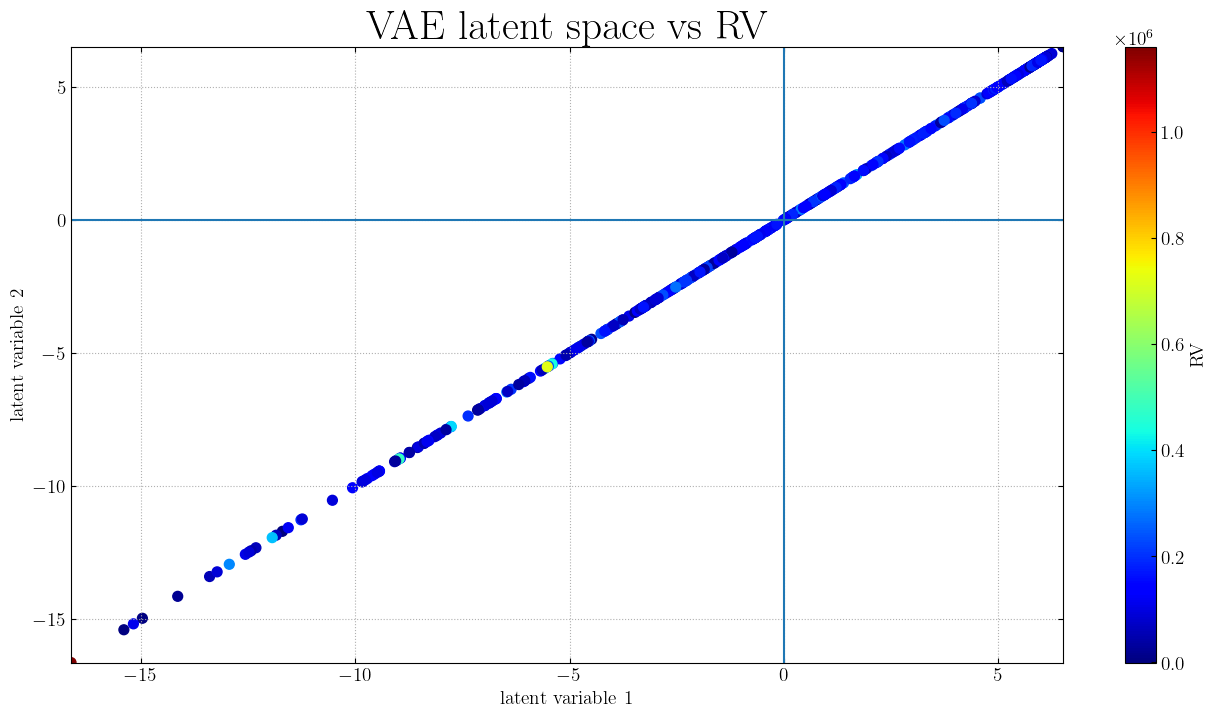

In [31]:
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(1,1,1)
#plt.scatter(all_latent_var[:,0],all_latent_var[:,1], c=col, edgecolors='face',marker="o" ,s=50)
#ax.errorbar(all_latent_var[:,0],all_latent_var[:,1], xerr=all_latent_sigma[:,0], yerr=all_latent_sigma[:,1],fmt='.',facecolor=None,ecolor='grey', elinewidth=1) 
im = ax.scatter(all_latent_var[:,0],all_latent_var[:,0], c=RV, edgecolors='face',marker="o" ,s=50,cmap="jet")
#             markeredgecolor=col,
#             markerfacecolor=col,
cbar = plt.colorbar(im,ax=ax)
cbar.set_label('RV')             
ax.set_title("VAE latent space vs RV",fontsize=30)
ax.set_xlabel("latent variable 1")
ax.set_ylabel("latent variable 2")
ax.axvline(0)
ax.axhline(0)
ax.grid()


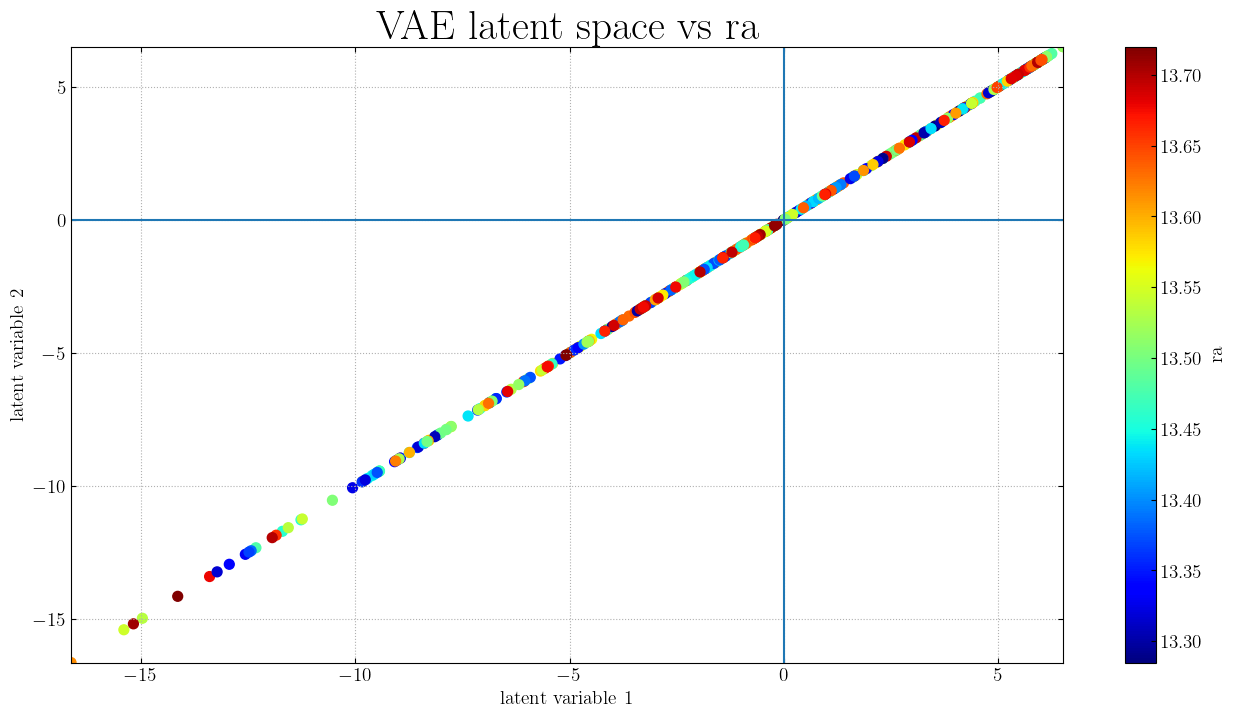

In [32]:
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(1,1,1)
#plt.scatter(all_latent_var[:,0],all_latent_var[:,1], c=col, edgecolors='face',marker="o" ,s=50)
#ax.errorbar(all_latent_var[:,0],all_latent_var[:,1], xerr=all_latent_sigma[:,0], yerr=all_latent_sigma[:,1],fmt='.',facecolor=None,ecolor='grey', elinewidth=1) 
im = ax.scatter(all_latent_var[:,0],all_latent_var[:,0], c=ra, edgecolors='face',marker="o" ,s=50,cmap="jet")
#             markeredgecolor=col,
#             markerfacecolor=col,
cbar = plt.colorbar(im,ax=ax)
cbar.set_label('ra')             
ax.set_title("VAE latent space vs ra",fontsize=30)
ax.set_xlabel("latent variable 1")
ax.set_ylabel("latent variable 2")
ax.axvline(0)
ax.axhline(0)
ax.grid()


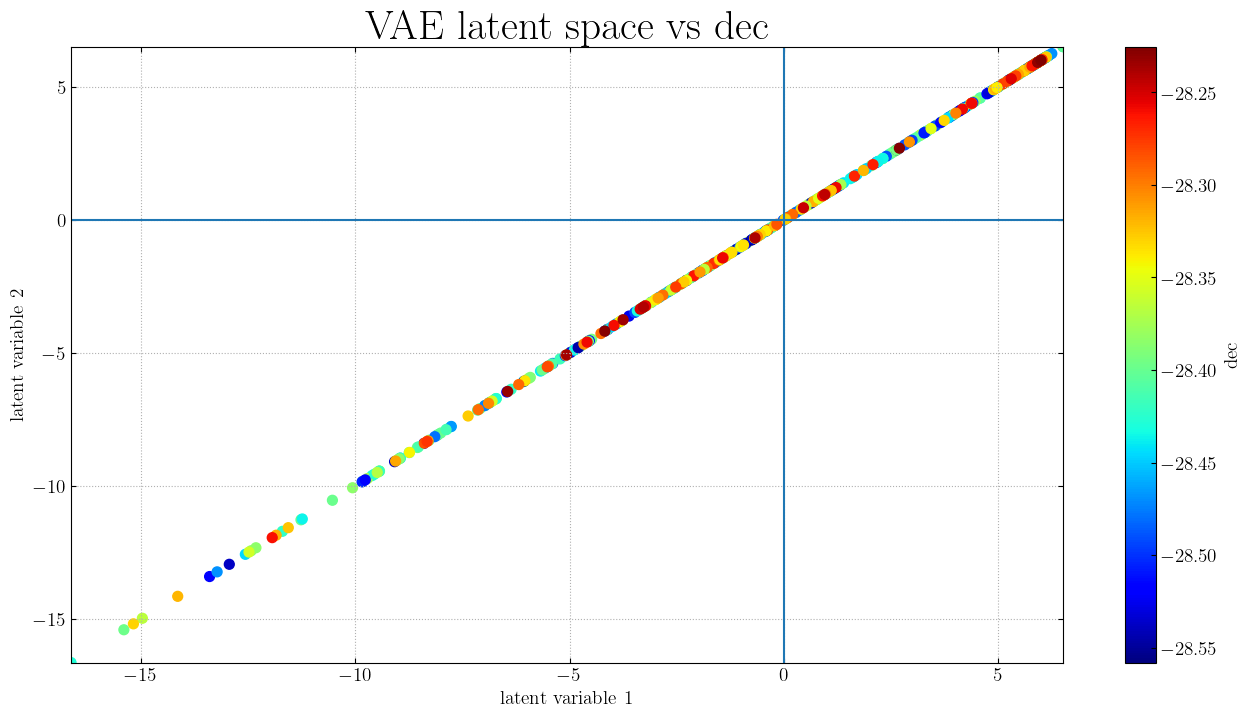

In [33]:
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(1,1,1)
#plt.scatter(all_latent_var[:,0],all_latent_var[:,1], c=col, edgecolors='face',marker="o" ,s=50)
#ax.errorbar(all_latent_var[:,0],all_latent_var[:,1], xerr=all_latent_sigma[:,0], yerr=all_latent_sigma[:,1],fmt='.',facecolor=None,ecolor='grey', elinewidth=1) 
im = ax.scatter(all_latent_var[:,0],all_latent_var[:,0], c=dec, edgecolors='face',marker="o" ,s=50,cmap="jet")
#             markeredgecolor=col,
#             markerfacecolor=col,
cbar = plt.colorbar(im,ax=ax)
cbar.set_label('dec')             
ax.set_title("VAE latent space vs dec",fontsize=30)
ax.set_xlabel("latent variable 1")
ax.set_ylabel("latent variable 2")
ax.axvline(0)
ax.axhline(0)
ax.grid()
